# Spatial Subdivision for Path Guiding in a Nutshell

This notebook summarizes the main ideas of our work "Spatial Subdivision for Path Guiding" and demonstrates our proposed algorithms in a simplified 2D scenario. The problem we consider typically arises in rendering, where we need to estimate the integral of a function over a high-dimensional domain. The function is often expensive to evaluate, and we can only access it through a Monte Carlo estimator. Our goal is to reduce the variance of the estimator by partitioning the domain into subregions and using different models to approximate the function in each subregion.

Our problem boils down to two main questions which we address respectively in this notebook:

1. Where to put the splitting plane to divide the domain into two subregions?
2. When to make the split and adopt the child model instead of the parent model?

## Context

On a 2D space $D = X \times Y = [-1, 1] \times (-\infty, +\infty)$ there is some ground truth distribution $p(x, y)$, with whom we have access to its unnormalized observation $f: D \rightarrow \mathbb{R}$ (with random noise). $I = \int_D f(x, y) dx dy$ is the normalizing constant, and so $p(x, y) = f(x, y) / I$.

Suppose we have fitted a 1D model that approximates the marginalized distribution $\hat{p}_Y(y) \propto \int_X p(y | x) \hat{p}_X(x) dx$ with a function $q_P(y)$.

It is known that the true distribution behaves very differently, when marginalized on $[-1, 0]$ and $[0, 1]$. We denote the two marginalized ones with $\hat{p}_{LY}(y) \propto \int_{-1}^0 p(y|x)\hat{p}_X(x) dx$ and $\hat{p}_{RY}(y) \propto \int_0^1 p(y|x)\hat{p}_X(x) dx$. Therefore, we have also fitted them respectively with left/right "child" models $q_L(y)$ and $q_R(y)$.

We define the "child model" as the ensemble of the two children:

$$ q_C(y | x) = \begin{cases} q_L(y) & \text{if } -1 \leq x \leq 0 \\ q_R(y) & \text{if } 0 < x \leq 1 \end{cases} $$

## Goal

The models described above are used to accelerate the Monte Carlo integration defined for each point in $X$ domain

$$ I(x) = \int_Y f(x, y) dy $$

Whose MC estimator is

$$ \langle I(x) \rangle = \frac{f(x, y)}{q(y | x)} $$

Where $q$ can be $q_P$ or $q_C$ in this context.

Now we want to decide between $q_P$ and $q_C$, which one generates less noise on the average sense of $X$ domain. (Note that the distribution $\hat{p}_X$ that we perform the measurement could be different from $p_X$)

$$ \mathrm{MSE} := \mathbb{E_{x \sim \hat{p}_X}} \mathbb{E} \left[ \left(\langle I(x) \rangle - I(x)\right)^2 \right] 
  = \mathbb{E_{x \sim \hat{p}_X}} \mathrm{Var} \left[ \langle I(x) \rangle \right]
$$


In [158]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_interactions import ipyplot as iplt
from scipy.integrate import quad
from scipy.special import erf
from scipy.optimize import minimize_scalar
import pomegranate
from pomegranate.gmm import GeneralMixtureModel
from pomegranate.distributions import Normal
# plt.rcParams['text.usetex'] = True
def print(*args):  # set float precision
    __builtins__.print(*("%.4f" % a if isinstance(a, float | np.floating) else a for a in args))
    
def uniform_stratified(low, high, num_samples, num_stratas):
    assert num_samples >= num_stratas and num_samples % num_stratas == 0
    samples = np.random.uniform(0, 1, num_samples)
    strata_width = (high - low) / num_stratas
    samples_per_strata = num_samples // num_stratas
    strata_indices = (np.arange(num_samples) / samples_per_strata).astype(int)
    return (strata_indices + samples) * strata_width + low

def normal(x, mu, std):
    return 1/np.sqrt(2*np.pi*std**2) * np.exp(-((x-mu)**2)/(2*std**2))

## Integrand Setup

Now, let's specialize our integrand below, where $x \leq 0$ corresponds to a "shadow" region, with some low frequency environment light.

$ x > 0 $ area has an extra sun light contribution, appeared as a spiky distribution around the origin.

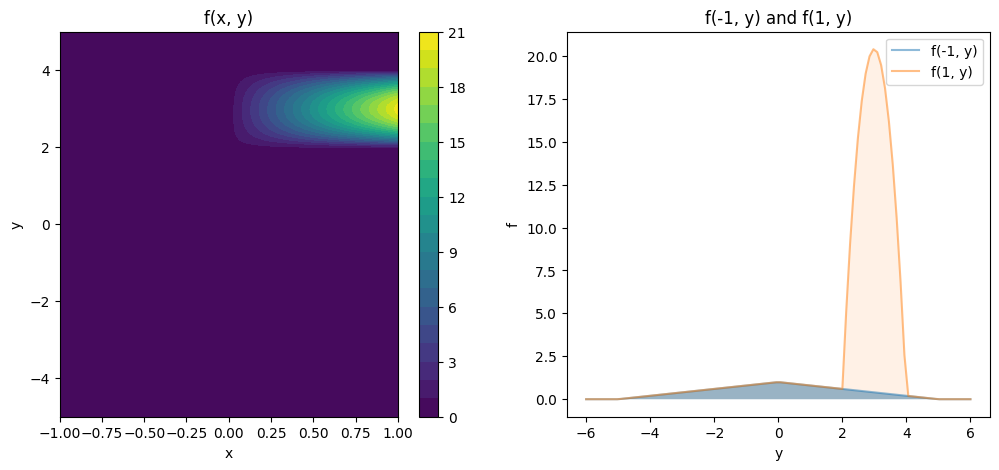

In [2]:
def f(x, y):
    return np.maximum(0, 5 - np.abs(y))/5 + (x > 0) * 20 * x * np.maximum(0, 1 - (y-3)**2)

N = 100
x = np.linspace(-1, 1, N)
y = np.linspace(-5, 5, N)
x, y = np.meshgrid(x, y)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plt.colorbar(ax1.contourf(x, y, f(x, y), 20))
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title('f(x, y)')

y = np.linspace(-6, 6, N)
ax2.plot(y, f(-1, y), label='f(-1, y)', alpha=0.5)
ax2.fill_between(y, 0, f(-1, y), alpha=0.5)
ax2.plot(y, f(1, y), label='f(1, y)', alpha=0.5)
ax2.fill_between(y, 0, f(1, y), alpha=0.1)
ax2.set_xlabel('y')
ax2.set_ylabel('f')
ax2.set_title('f(-1, y) and f(1, y)')
ax2.legend()
plt.show()

Let's compute the analytic solution for $I(x)$ and $I$.

In [3]:
def I(x):
    return 5 + (x > 0) * 80/3 * x

Ixy = 10 + 40/3

def p(x, y):
    return f(x, y)/Ixy

def px(x):  # marginalized on y
    return I(x)/Ixy

def py_x(y, x):  # conditional distribution
    return f(x, y)/I(x)

def py(y):  # marginalized on x
    return (0.4 * np.maximum(0, 5 - np.abs(y)) + 10 * np.maximum(0, 1 - (y-3)**2)) / Ixy

# Validate the integrals
print(I(1), quad(lambda y: f(1, y), -5, 5))
print(Ixy, quad(I, -1, 1), quad(lambda x: quad(lambda y: f(x, y), -5, 5)[0], -1, 1))
print(1, quad(px, -1, 1))
print(1, quad(py, -5, 5))
print(1, quad(lambda x: quad(lambda y: p(x, y), -5, 5)[0], -1, 1))

31.666666666666668 (31.666666666666668, 3.515706244646329e-14)
23.333333333333336 (23.333333333333332, 2.5934809855243657e-13) (23.333333333529183, 1.326938559031987e-12)
1 (1.0, 1.1102230246251565e-14)
1 (0.9999999999999996, 1.1102230246251561e-15)
1 (1.0000000000046532, 1.1102230246251565e-14)


In [86]:
# %matplotlib ipympl
# N = 100
# y = np.linspace(-6, 6, N)
# fig, ax = plt.subplots()
# iplt.plot(y, lambda y, x_cond: py_x(y, x_cond), x_cond=(-1, 1, N))
# plt.xlabel('y')
# plt.ylabel('p(y|x)')
# plt.show()

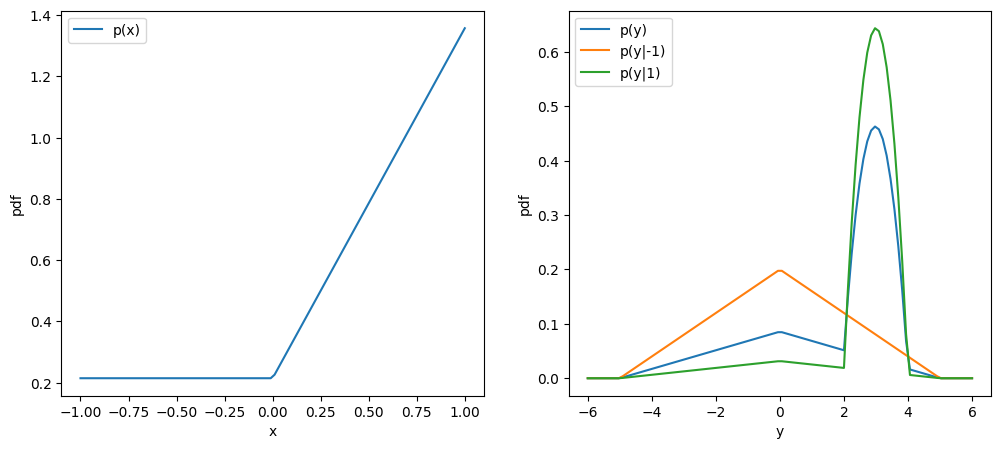

In [4]:
plt.close()
%matplotlib inline
x = np.linspace(-1, 1, N)
y = np.linspace(-6, 6, N)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(x, px(x), label='p(x)')
ax1.set_xlabel('x')
ax1.set_ylabel('pdf')
ax1.legend()

ax2.plot(y, py(y), label='p(y)')
ax2.plot(y, py_x(y, -1), label='p(y|-1)')
ax2.plot(y, py_x(y, 1), label='p(y|1)')
ax2.set_xlabel('y')
ax2.set_ylabel('pdf')
ax2.legend()
plt.show()

## Train Models

Now, let's train the parent and child models using Gaussian Mixtures.

In [5]:
# Generate training data for learning the models
training_samples = 1000
noise_level = 1e-2

def hat_px(x):  # sampling distribution of x
    return np.full_like(x, 0.5)

@np.vectorize
def hat_py_unnorm(y):
    return quad(lambda x: py_x(y, x) * hat_px(x), -1, 1)[0]

hat_py_normalizer = quad(hat_py_unnorm, -5, 5)[0]

def hat_py(y):  # propto \int p(y|x) \hat{p}_X(x) dx
    return hat_py_unnorm(y) / hat_py_normalizer

@np.vectorize
def hat_ply_unnorm(y):
    return quad(lambda x: py_x(y, x) * hat_px(x), -1, 0)[0]

hat_ply_normalizer = quad(hat_ply_unnorm, -5, 5)[0]

def hat_ply(y):
    return hat_ply_unnorm(y) / hat_ply_normalizer

@np.vectorize
def hat_pry_unnorm(y):
    return quad(lambda x: py_x(y, x) * hat_px(x), 0, 1)[0]

hat_pry_normalizer = quad(hat_pry_unnorm, -5, 5)[0]

def hat_pry(y):
    return hat_pry_unnorm(y) / hat_pry_normalizer

X_train = np.random.uniform(-1, 1, training_samples)
Y_train = np.random.uniform(-5, 5, training_samples)
Psy_train = np.full_like(Y_train, fill_value=1/10)  # sampling pdf of y
Z_train = f(X_train, Y_train)
Z_train[Z_train > 0] = np.random.gamma(Z_train[Z_train > 0]**2 / noise_level, noise_level / Z_train[Z_train > 0])  # add noise

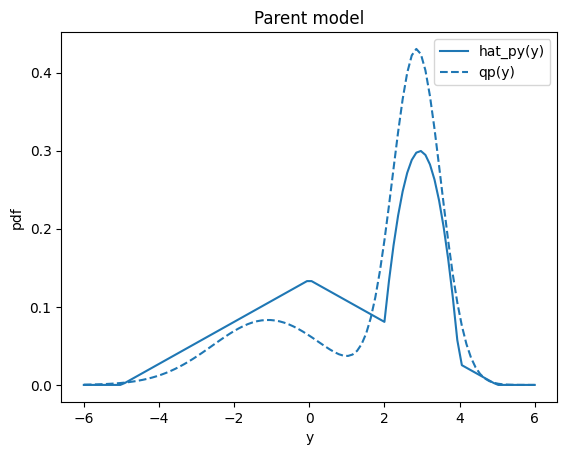

In [6]:
# Train the parent model
gmm_p = GeneralMixtureModel([Normal(), Normal()])
samples = Y_train[:, None].astype(np.float32)
weights = (Z_train / Psy_train)[:, None].astype(np.float32)
gmm_p.fit(samples, weights)

def qp(y):
    return gmm_p.probability(y[:, None]).numpy()

# Plot the learned distribution
N = 100
y = np.linspace(-6, 6, N)
plt.figure()
plt.plot(y, hat_py(y), label='hat_py(y)', linestyle='-', color='tab:blue')
plt.plot(y, qp(y), label='qp(y)', linestyle='--', color='tab:blue')
plt.xlabel('y')
plt.ylabel('pdf')
plt.legend()
plt.title('Parent model')
plt.show()

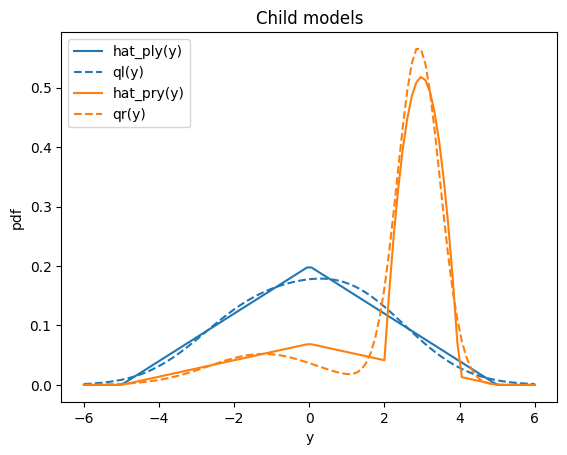

In [7]:
# Train the child model
gmm_l = GeneralMixtureModel([Normal(), Normal()])
gmm_r = GeneralMixtureModel([Normal(), Normal()])
samples_l = samples[X_train <= 0]
weights_l = weights[X_train <= 0]
gmm_l.fit(samples_l, weights_l)
samples_r = samples[X_train > 0]
weights_r = weights[X_train > 0]
gmm_r.fit(samples_r, weights_r)

def ql(y):
    return gmm_l.probability(y[:, None]).numpy()

def qr(y):
    return gmm_r.probability(y[:, None]).numpy()

# Plot the learned distribution
N = 100
y = np.linspace(-6, 6, N)
plt.figure()
# plt.plot(y, py_x(y, -1), label='p(y|-1)')
# plt.plot(y, py_x(y, 1), label='p(y|1)')
plt.plot(y, hat_ply(y), label='hat_ply(y)', linestyle='-', color='tab:blue')
plt.plot(y, ql(y), label='ql(y)', linestyle='--', color='tab:blue')
plt.plot(y, hat_pry(y), label='hat_pry(y)', linestyle='-', color='tab:orange')
plt.plot(y, qr(y), label='qr(y)', linestyle='--', color='tab:orange')
plt.xlabel('y')
plt.ylabel('pdf')
plt.legend()
plt.title('Child models')
plt.show()

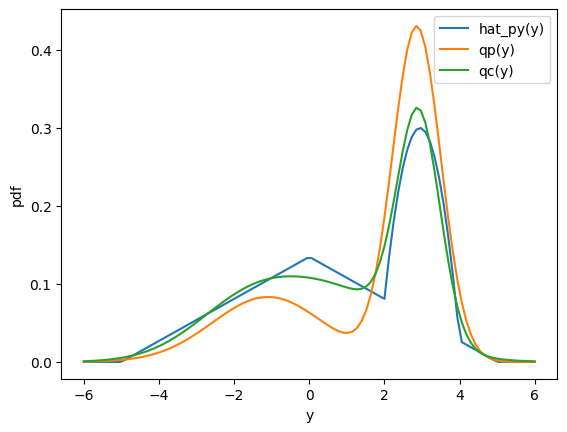

In [8]:
# Show the ensemble model of children

def qc_y_x(y, x):  # conditioned on x
    return np.where(x <= 0, ql(y), qr(y))

@np.vectorize
def qc_y_unnorm(y):  # marginalized
    return quad(lambda x: ql(np.array([y])) * hat_px(x), -1, 0)[0] + quad(lambda x: qr(np.array([y])) * hat_px(x), 0, 1)[0]

qc_y_normalizer = quad(qc_y_unnorm, -5, 5)[0]

def qc_y(y):
    return qc_y_unnorm(y) / qc_y_normalizer

# Plot the learned distribution
N = 100
y = np.linspace(-6, 6, N)
plt.figure()
plt.plot(y, hat_py(y), label='hat_py(y)')
plt.plot(y, qp(y), label='qp(y)')
plt.plot(y, qc_y(y), label='qc(y)')
plt.xlabel('y')
plt.ylabel('pdf')
plt.legend()
plt.show()

## MSE Evaluation

Now we compute the MC integration MSE for the two models.

In [9]:
# Generate validating data for MC integration
validating_samples = 1000000

X_val = np.random.uniform(-1, 1, validating_samples)
Y_val_p = gmm_p.sample(validating_samples).numpy()[:, 0]
Y_val_l = gmm_l.sample(validating_samples).numpy()[:, 0]
Y_val_r = gmm_r.sample(validating_samples).numpy()[:, 0]
Y_val_c = np.where(X_val <= 0, Y_val_l, Y_val_r)

ests_p = f(X_val, Y_val_p) / qp(Y_val_p)
ests_l = f(X_val, Y_val_l) / ql(Y_val_l)
ests_r = f(X_val, Y_val_r) / qr(Y_val_r)
ests_c = f(X_val, Y_val_c) / qc_y_x(Y_val_c, X_val)
truths = I(X_val)

def ME(estimates, truths):
    return np.mean(estimates - truths)

def MSE(estimates, truths):
    return np.mean((estimates - truths)**2)

def relMSE(estimates, truths):
    return np.mean((estimates - truths)**2 / (truths**2 + 0.01))

print('ME:')
print('parent,   whole space, left, right:', ME(ests_p, truths), ME(ests_p[X_val <= 0], truths[X_val <= 0]), ME(ests_p[X_val > 0], truths[X_val > 0]))
print('children, whole space, left, right:', ME(ests_c, truths), ME(ests_l[X_val <= 0], truths[X_val <= 0]), ME(ests_r[X_val > 0], truths[X_val > 0]))
print()

print('MSE:')
print('parent,   whole space, left, right:', MSE(ests_p, truths), MSE(ests_p[X_val <= 0], truths[X_val <= 0]), MSE(ests_p[X_val > 0], truths[X_val > 0]))
print('children, whole space, left, right:', MSE(ests_c, truths), MSE(ests_l[X_val <= 0], truths[X_val <= 0]), MSE(ests_r[X_val > 0], truths[X_val > 0]))
print()

print('relMSE:')
print('parent,   whole space, left, right:', relMSE(ests_p, truths), relMSE(ests_p[X_val <= 0], truths[X_val <= 0]), relMSE(ests_p[X_val > 0], truths[X_val > 0]))
print('children, whole space, left, right:', relMSE(ests_c, truths), relMSE(ests_l[X_val <= 0], truths[X_val <= 0]), relMSE(ests_r[X_val > 0], truths[X_val > 0]))

ME:
parent,   whole space, left, right: -0.0179 -0.0090 -0.0267
children, whole space, left, right: 0.0001 0.0002 0.0001

MSE:
parent,   whole space, left, right: 68.2712 29.8984 106.7152
children, whole space, left, right: 27.2842 0.5209 54.0972

relMSE:
parent,   whole space, left, right: 0.7247 1.1955 0.2530
children, whole space, left, right: 0.1647 0.0208 0.3089


So this concludes that the child model approximates the true signals more accurately than the parent one thanks to the fact that it splits the space into two, and has higher representational power.

The downside is that child model has access to fewer samples than the parent, incurring higher variance in the learning. This can be manifested when the noise level is high, samples are not enough, or when the modality of the distribution does not change on $X$.

## Theoretically Optimal Model

So far, we have seen the issue of spatial marginalization, which incurs an intrinsic variance in the MC integration. No matter how well the mixture model learns the distribution, the variance is always there. To show undertand this variance better, we can derive the theoretically best distribution $q^*$ that minimizes the relative MSE.

$$

q^* = \argmin_{q, \int_Y q(y) dy = 1} \mathrm{relMSE}(q) \\

\mathrm{relMSE}(q) = \mathbb{E_{x \sim \hat{p}_X}} \mathrm{Var}_{y \sim q} \left[ \frac{ \langle I(x) \rangle }{I(x)} \right]
= \mathbb{E_{x \sim \hat{p}_X}} \mathrm{Var}_{y \sim q} \left[ \frac{f(x, y)}{I(x) q(y)} \right] \\
= \mathbb{E_{x \sim \hat{p}_X}} \left[ \int \frac{f(x, y)^2}{I(x)^2 q(y)} dy \right] - 1

$$

Expressing the minimization problem into variational calculus

$$

q^* = \argmin_{q} \int \frac{1}{q(y)} \mathbb{E_{x \sim \hat{p}_X}} \left[\frac{f(x, y)^2}{I(x)^2}\right] dy + \lambda \left( \int q(y) dy - 1 \right)
= \argmin_{q} \int L(y, q, \lambda) dy

$$

Using the Euler-Lagrange equation $ \frac{\partial L}{\partial q} - \frac{d}{dy} \frac{\partial L}{\partial q'} = 0 $, we can find the optimal distribution:

$$

q^*(y) = \sqrt{ \mathbb{E}_{x \sim \hat{p}_X} \left[ \frac{f(x, y)^2}{I(x)^2} \right] } / C
 = \sqrt{ \mathbb{E}_{x \sim \hat{p}_X} \left[ p(y | x)^2 \right] } / C \\
C = \int \sqrt{ \mathbb{E}_{x \sim \hat{p}_X} \left[ p(y | x)^2 \right] } dy

$$

Substituting it back to the relMSE, we get the theoretical optimal:

$$

\mathrm{relMSE}(q^*) = \mathbb E_{x \sim \hat{p}_X} \left[ \int \frac{f(x, y)^2}{I(x)^2 q^*(y)} dy \right] - 1 \\
 = C \int \frac{\mathbb E_{x \sim \hat{p}_X} \left[ p(y | x)^2 \right] }{\sqrt{ \mathbb{E}_{x \sim \hat{p}_X} \left[ p(y | x)^2 \right] }} dy - 1 
 = C \int \sqrt{ \mathbb{E}_{x \sim \hat{p}_X} \left[ p(y | x)^2 \right] } dy - 1 \\
 = \left(\int \sqrt{ \mathbb{E}_{x \sim \hat{p}_X} \left[ p(y | x)^2 \right] } dy\right)^2 - 1

$$



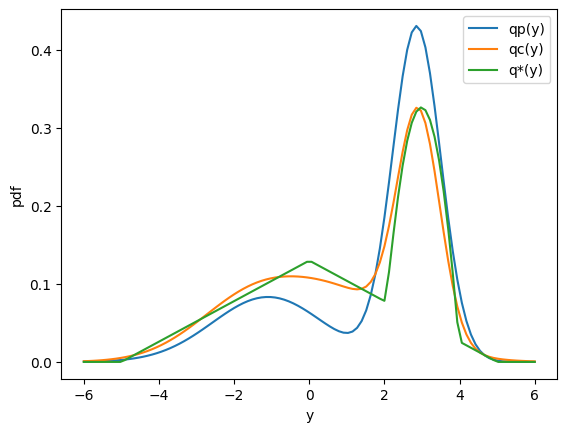

In [13]:
# Calculate the theoretically optimal distribution

@np.vectorize
def q_star_unnorm(y):
    return np.sqrt(quad(lambda x: hat_px(x) * py_x(y, x)**2, -1, 1)[0])

q_star_unnormalizer = quad(q_star_unnorm, -5, 5)[0]

def q_star(y):
    return q_star_unnorm(y) / q_star_unnormalizer

q_star_y_key_points = np.linspace(-5, 5, 1000)
q_star_fp_key_points = q_star(q_star_y_key_points)

def q_star_approx(y):
    return np.interp(y, q_star_y_key_points, q_star_fp_key_points)

# Plot the learned distributions and the optimal distribution
N = 100
y = np.linspace(-6, 6, N)
plt.figure()
plt.plot(y, qp(y), label='qp(y)')
plt.plot(y, qc_y(y), label='qc(y)')
plt.plot(y, q_star_approx(y), label='q*(y)')
plt.xlabel('y')
plt.ylabel('pdf')
plt.legend()
plt.show()

In [14]:
# Compute the relMSE of the optimal distribution
def relMSE_quad(q):
    return quad(lambda x: hat_px(x) * quad(lambda y: (f(x, y)/I(x) - q(y))**2 / q(y), -5, 5)[0], -1, 1)[0]

def relMSE_optimal(hat_px, py_x):
    return quad(lambda y: np.sqrt(quad(lambda x: hat_px(x) * py_x(y, x)**2, -1, 1)[0]), -5, 5)[0]**2 - 1

print('relMSE of the optimal distribution:', relMSE_quad(q_star_approx))
print('relMSE using formula              :', relMSE_optimal(hat_px, py_x))
# print('relMSE of the parent model:        ', relMSE_quad(lambda y: gmm_p.probability([[y]]).numpy()))

/var/folders/rn/zlh0ft7s6rq_33ccg6kbf1qr0000gn/T/ipykernel_64037/4134176495.py:3: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return quad(lambda x: hat_px(x) * quad(lambda y: (f(x, y)/I(x) - q(y))**2 / q(y), -5, 5)[0], -1, 1)[0]
/var/folders/rn/zlh0ft7s6rq_33ccg6kbf1qr0000gn/T/ipykernel_64037/4134176495.py:3: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return quad(lambda x: hat_px(x) * quad(lambda y: (f(x, y)/I(x) - q(y))**2 / q(y), -5, 5)[0], -1, 1)[0]


relMSE of the optimal distribution: 0.3740387506183332
relMSE using formula              : 0.3740386965231395


In [53]:
mu1, std1 = 0, 1
mu2, std2 = 0.5, 2

p1_normalizer = 1/2 * erf((5-mu1)/(np.sqrt(2)*std1)) - 1/2 * erf((-5-mu1)/(np.sqrt(2)*std1))
p2_normalizer = 1/2 * erf((5-mu2)/(np.sqrt(2)*std2)) - 1/2 * erf((-5-mu2)/(np.sqrt(2)*std2))

def p1(y):
    return normal(y, mu1, std1) / p1_normalizer

def p2(y):
    return normal(y, mu2, std2) / p2_normalizer

print(quad(lambda y: p1(y), -5, 5)[0])
print(quad(lambda y: p2(y), -5, 5)[0])

a = 0.5
quad(lambda y: np.sqrt(a * p1(y)**2 + (1 - a) * p2(y)**2), -5, 5)[0]**2 - 1

1.0000000000000002
1.0


0.1567246419099415

## End-to-end Tests

In [141]:
# Problem definition
plot_learned = True
###### Case 1 ###### whether to split depends on k
xmin, xmid, xmax = -1, 0, 1
ymin, ymax = -np.pi, np.pi
k = 1

def f(x, y):
    return 1-np.cos(2*y + k*x)

def I(x):
    return 1*(ymax - ymin) - 0.5*(np.sin(2*ymax + k*x) - np.sin(2*ymin + k*x))

###### Case 2 ###### should split
# xmin, xmid, xmax = -1, 0, 1
# ymin, ymax = -3, 3

# def f(x, y):
#     return np.where(x <= 0, normal(y, -1, 0.1), normal(y, -1, 0.1) + 2 * normal(y, 1, 0.5))

# def I(x):
#     return np.where(x <= 0, 1, 3)

###### Case 3 ######  left: sun + environ, right: environ, whether to split is sensitive to xmid
# xmin, xmid, xmax = -1, +0.2, 1
# ymin, ymax = -5, 5
# scale = 0.2

# def gate(x):
#     return np.clip(1-(x+0.5*scale)/scale, 0, 1)

# def f(x, y):
#     return 10 * gate(x) * normal(y, 0, 0.05) + 1/(ymax - ymin)

# def I(x):
#     return 10 * gate(x) + 1

##### Uncomment this for arbitarily defined f #####
# @np.vectorize
# def I(x):
#     return quad(lambda y: f(x, y), ymin, ymax)[0]

Ixy = quad(lambda x: I(x), xmin, xmax)[0]

def p(x, y):
    return f(x, y) / Ixy

def py_x(y, x):
    return f(x, y) / I(x)

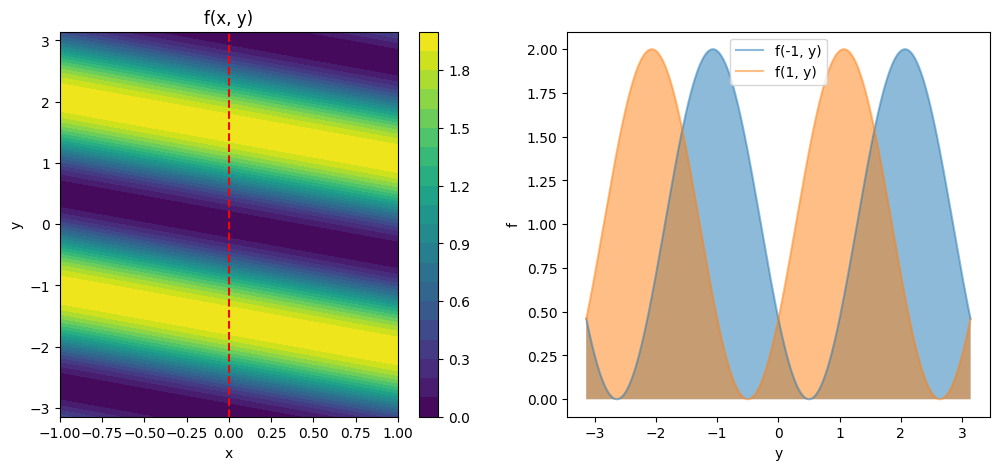

In [142]:
N = 1000
x = np.linspace(xmin, xmax, N)
y = np.linspace(ymin, ymax, N)
x, y = np.meshgrid(x, y)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plt.colorbar(ax1.contourf(x, y, f(x, y), 20))
ax1.axvline(x=xmid, color='red', linestyle='--')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title('f(x, y)')

y = np.linspace(ymin, ymax, N)
ax2.plot(y, f(xmin, y), label=f'f({xmin}, y)', alpha=0.5)
ax2.fill_between(y, 0, f(xmin, y), alpha=0.5)
ax2.plot(y, f(xmax, y), label=f'f({xmax}, y)', alpha=0.5)
ax2.fill_between(y, 0, f(xmax, y), alpha=0.5)
ax2.set_xlabel('y')
ax2.set_ylabel('f')
ax2.legend()
plt.show()

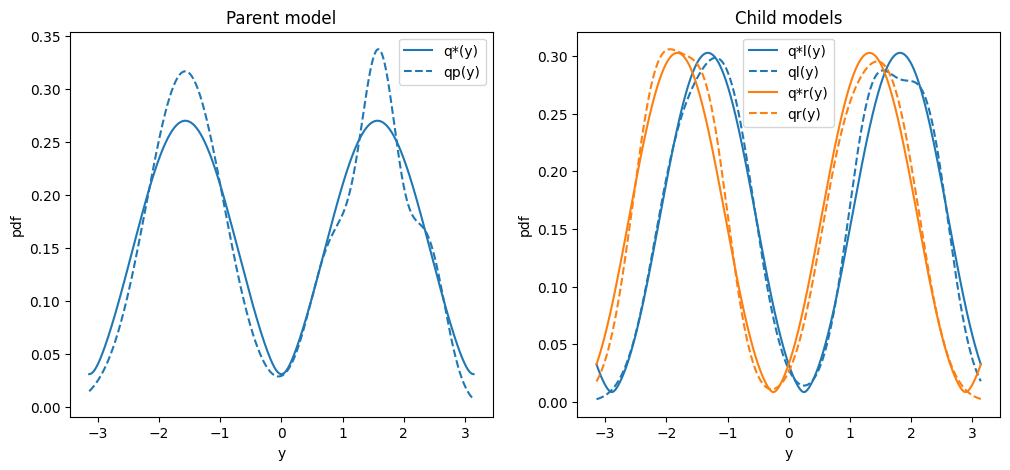

ME:
parent,   whole space, left, right: 0.0020 -0.0022 0.0061
children, whole space, left, right: -0.0019 -0.0024 -0.0014

MSE:
parent,   whole space, left, right: 9.0437 9.2883 8.7993
children, whole space, left, right: 3.6872 3.6616 3.7128

relMSE:
parent,   whole space, left, right: 0.2290 0.2352 0.2228
children, whole space, left, right: 0.0934 0.0927 0.0940
optimal,  whole space, left, right: 0.0615 0.0615 0.0615


In [143]:
# Generate training data for learning the models
training_samples = 10000
noise_level = 1e-2
n_components = 4

def f_noisy(x, y):  # noisy observation
    z = f(x, y)
    if noise_level > 0:
        z[z > 1e-3] = np.random.gamma(z[z > 1e-3]**2 / noise_level, noise_level / z[z > 1e-3]) # add noise
    return z

X_train = uniform_stratified(xmin, xmax, training_samples, training_samples)
Y_train = uniform_stratified(ymin, ymax, training_samples, training_samples)
np.random.shuffle(Y_train)
Psy_train = np.full_like(Y_train, fill_value=1/(ymax - ymin))  # sampling pdf of y
Z_train = f_noisy(X_train, Y_train)

# Train the parent model
gmm_p = GeneralMixtureModel([Normal() for _ in range(n_components)])
samples = Y_train[:, None].astype(np.float32)
weights = (Z_train / Psy_train)[:, None].astype(np.float32)
gmm_p.fit(samples[weights[:, 0] > 0], weights[weights[:, 0] > 0])

def qp(y):
    return gmm_p.probability(y[:, None]).numpy()

# Train the child model
gmm_l = GeneralMixtureModel([Normal() for _ in range(n_components)])
gmm_r = GeneralMixtureModel([Normal() for _ in range(n_components)])
samples_l = samples[X_train <= xmid]
weights_l = weights[X_train <= xmid]
gmm_l.fit(samples_l[weights_l[:, 0] > 0], weights_l[weights_l[:, 0] > 0])
samples_r = samples[X_train > xmid]
weights_r = weights[X_train > xmid]
gmm_r.fit(samples_r[weights_r[:, 0] > 0], weights_r[weights_r[:, 0] > 0])

def ql(y):
    return gmm_l.probability(y[:, None]).numpy()

def qr(y):
    return gmm_r.probability(y[:, None]).numpy()

def qc_y_x(y, x):  # conditioned on x
    return np.where(x <= xmid, ql(y), qr(y))

# Plot the learned distribution
if plot_learned:
    # Define some marginalized distributions

    # @np.vectorize
    # def hat_py_unnorm(y):
    #     return quad(lambda x: f(x, y) * hat_px(x) / I(x), xmin, xmax)[0]

    # hat_py_normalizer = quad(hat_py_unnorm, ymin, ymax)[0]

    # def hat_py(y):  # propto \int p(y|x) \hat{p}_X(x) dx
    #     return hat_py_unnorm(y) / hat_py_normalizer

    # @np.vectorize
    # def hat_ply_unnorm(y):
    #     return quad(lambda x: f(x, y) * hat_px(x) / I(x), xmin, xmid)[0]

    # hat_ply_normalizer = quad(hat_ply_unnorm, ymin, ymax)[0]

    # def hat_ply(y):
    #     return hat_ply_unnorm(y) / hat_ply_normalizer

    # @np.vectorize
    # def hat_pry_unnorm(y):
    #     return quad(lambda x: f(x, y) * hat_px(x) / I(x), xmid, xmax)[0]

    # hat_pry_normalizer = quad(hat_pry_unnorm, ymin, ymax)[0]

    # def hat_pry(y):
    #     return hat_pry_unnorm(y) / hat_pry_normalizer
    
    # Calculate the theoretically optimal distribution
    def find_q_star(hat_px, py_x, xmin, xmax, ymin, ymax):
        @np.vectorize
        def q_star_unnorm(y):
            return np.sqrt(quad(lambda x: hat_px(x) * py_x(y, x)**2, xmin, xmax)[0])

        q_star_unnormalizer = quad(q_star_unnorm, ymin, ymax)[0]

        def q_star(y):
            return q_star_unnorm(y) / q_star_unnormalizer

        q_star_y_key_points = np.linspace(ymin, ymax, 1000)
        q_star_fp_key_points = q_star(q_star_y_key_points)

        def q_star_approx(y):
            return np.interp(y, q_star_y_key_points, q_star_fp_key_points)
        
        return q_star_approx
    
    q_star = find_q_star(hat_px, py_x, xmin, xmax, ymin, ymax)
    q_star_l = find_q_star(hat_px, py_x, xmin, xmid, ymin, ymax)
    q_star_r = find_q_star(hat_px, py_x, xmid, xmax, ymin, ymax)
    
    N = 1000
    y = np.linspace(ymin, ymax, N)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    # ax1.plot(y, hat_py(y), label='hat_py(y)', linestyle='-', color='tab:blue')
    ax1.plot(y, q_star(y), label='q*(y)', linestyle='-', color='tab:blue')
    ax1.plot(y, qp(y), label='qp(y)', linestyle='--', color='tab:blue')
    ax1.set_xlabel('y')
    ax1.set_ylabel('pdf')
    ax1.legend()
    ax1.set_title('Parent model')

    # ax2.plot(y, hat_ply(y), label='hat_ply(y)', linestyle='-', color='tab:blue')
    ax2.plot(y, q_star_l(y), label='q*l(y)', linestyle='-', color='tab:blue')
    ax2.plot(y, ql(y), label='ql(y)', linestyle='--', color='tab:blue')
    # ax2.plot(y, hat_pry(y), label='hat_pry(y)', linestyle='-', color='tab:orange')
    ax2.plot(y, q_star_r(y), label='q*r(y)', linestyle='-', color='tab:orange')
    ax2.plot(y, qr(y), label='qr(y)', linestyle='--', color='tab:orange')
    ax2.set_xlabel('y')
    ax2.set_ylabel('pdf')
    ax2.legend()
    ax2.set_title('Child models')

    plt.show()

##### Evaluation #####
# Generate validating data for MC integration
validating_samples = 1000000

# X_val = uniform_stratified(xmin, xmax, validating_samples, validating_samples)
X_val = np.random.uniform(xmin, xmax, validating_samples)
Y_val_p = gmm_p.sample(validating_samples).numpy()[:, 0]
Y_val_l = gmm_l.sample(validating_samples).numpy()[:, 0]
Y_val_r = gmm_r.sample(validating_samples).numpy()[:, 0]
Y_val_c = np.where(X_val <= xmid, Y_val_l, Y_val_r)

ests_p = np.where((ymin <= Y_val_p) & (Y_val_p < ymax), f(X_val, Y_val_p), 0) / qp(Y_val_p)
ests_l = np.where((ymin <= Y_val_l) & (Y_val_l < ymax), f(X_val, Y_val_l), 0) / ql(Y_val_l)
ests_r = np.where((ymin <= Y_val_r) & (Y_val_r < ymax), f(X_val, Y_val_r), 0) / qr(Y_val_r)
ests_c = np.where((ymin <= Y_val_c) & (Y_val_c < ymax), f(X_val, Y_val_c), 0) / qc_y_x(Y_val_c, X_val)
truths = I(X_val)

def ME(estimates, truths):
    return np.mean(estimates - truths)

def MSE(estimates, truths):
    return np.mean((estimates - truths)**2)

def relMSE(estimates, truths):
    return np.mean((estimates - truths)**2 / (truths**2 + 0.01))

def relMSE_optimal(hat_px, py_x, xmin, xmax, ymin, ymax):
    return quad(lambda y: np.sqrt(quad(lambda x: hat_px(x) * py_x(y, x)**2, xmin, xmax)[0]), ymin, ymax)[0]**2 - 1

print('ME:')
print('parent,   whole space, left, right:', ME(ests_p, truths), ME(ests_p[X_val <= xmid], truths[X_val <= xmid]), ME(ests_p[X_val > xmid], truths[X_val > xmid]))
print('children, whole space, left, right:', ME(ests_c, truths), ME(ests_l[X_val <= xmid], truths[X_val <= xmid]), ME(ests_r[X_val > xmid], truths[X_val > xmid]))
print()

print('MSE:')
print('parent,   whole space, left, right:', MSE(ests_p, truths), MSE(ests_p[X_val <= xmid], truths[X_val <= xmid]), MSE(ests_p[X_val > xmid], truths[X_val > xmid]))
print('children, whole space, left, right:', MSE(ests_c, truths), MSE(ests_l[X_val <= xmid], truths[X_val <= xmid]), MSE(ests_r[X_val > xmid], truths[X_val > xmid]))
print()

print('relMSE:')
print('parent,   whole space, left, right:', relMSE(ests_p, truths), relMSE(ests_p[X_val <= xmid], truths[X_val <= xmid]), relMSE(ests_p[X_val > xmid], truths[X_val > xmid]))
print('children, whole space, left, right:', relMSE(ests_c, truths), relMSE(ests_l[X_val <= xmid], truths[X_val <= xmid]), relMSE(ests_r[X_val > xmid], truths[X_val > xmid]))
error_opt_l, error_opt_r = relMSE_optimal(hat_plx, py_x, xmin, xmid, ymin, ymax), relMSE_optimal(hat_prx, py_x, xmid, xmax, ymin, ymax)
error_opt = Plx * error_opt_l + Prx * error_opt_r
print('optimal,  whole space, left, right:', error_opt, error_opt_l, error_opt_r)

## Divergence Metric Evaluation

In the rendering application, we have no access to the true integral $I(x)$.  Instead, all observations we have are *noisy* estimates of the integrand $f(x, y)$.

Hence, we propose an empirical KL divergence metric that can be used to determine the quality of the model. The metric is defined as follows:

$$

D^{\hat{p}_X}_{KL} (p || q) := \mathbb{E}_{x \sim \hat{p_X}} \left[ D_{KL}(p_{Y|X} || q_{Y|X}) \right]

$$

Where the $D^{\hat{p}_X}$ denotes that the divergence is averaged over the empirical distribution $\hat{p}_X$. $D_{KL}(p_{Y|X} || q_{Y|X})$ computes the divergence between two conditional distributions - the true $p_{Y|X}$ and the learned model $q_{Y|X}$.

Note that KL divergence boils down to the subtraction of two entropies:

$$

D_{KL}(p || q) = H(p, q) - H(p) 

$$

Where $H(p, q) = - \mathbb{E}_p \log q$ is the cross entropy between the two distributions, $H(p) = - \mathbb{E}_p \log p$ is the entropy of the true distribution.

Pluging this into the definition of the divergence metric, we get:

$$

D^{\hat{p}_X}_{KL} (p || q) = \mathbb{E}_{x \sim \hat{p}_X} \left[ H(p_{Y|X}, q_{Y|X}) \right] - \mathbb{E}_{x \sim \hat{p}_X} \left[ H(p_{Y|X}) \right]

$$

The second term on the right hand side is a constant for parent and child models. Hence, we only care about the cross entropy, which we compute using the following MC estimator:

$$

\mathbb{E}_{x \sim \hat{p}_X} \left[ H(p_{Y|X}, q_{Y|X}) \right] 
 = \mathbb{E}_{x \sim \hat{p}_X} \left[   -\int p(y | x) \log q(y | x) dy   \right] \\
 = \mathbb{E}_{x \sim \hat{p}_X} \left[   \mathbb{E}_{y \sim q_s} \left[ -\frac{p(y | x)}{q_s(y | x)} \log q(y|x) \right]   \right]
 \approx \frac{1}{N} \sum_{i=1}^N \left[ -\frac{p(y_i | x_i)}{q_s(y_i | x_i)} \log q(y_i|x_i) \right]

$$

Where $q_s$ is the pdf of the MC samples $y_i$ at $x_i$, and $x_i$ follows the distribution $\hat{p}_X$.

Note that we have no access to the true probability $p(y|x)$, but only the noisy estimate $\langle f(x, y) \rangle$. Using the relation $p(y|x) = f(x, y) / I(x) = \frac{f(x, y)}{\int f(x, y) dy}$, and $\langle I(x) \rangle = \langle f(x, y) \rangle / q_s(y | x)$, we can rewrite the above estimator as:

$$

\mathbb{E}_{x \sim \hat{p}_X} \left[ H(p_{Y|X}, q_{Y|X}) \right] 
 = \mathbb{E}_{x \sim \hat{p}_X, y \sim q_s} \left[ -\frac{ f(x, y) }{I(x) q_s(y | x)} \log q(y|x) \right] \\
 = \mathbb{E}_{x \sim \hat{p}_X, y \sim q_s} \left[ -\frac{ \mathbb E \left[ \langle f(x, y) \rangle \right] }{I(x) q_s(y | x)} \log q(y|x) \right] 
 \approx \textcolor{green}{\frac{1}{N} \sum_{i=1}^N -\frac{ \langle I(x_i) \rangle }{I(x_i)} \log q(y_i|x_i)} \\
 \doteq \frac{\frac{1}{N}\sum_{i=1}^N -\langle I(x_i) \rangle \log q(y_i|x_i) } { \frac{1}{N}\sum_{i=1}^N \langle I(x_i) \rangle }
 = \textcolor{orange}{\frac{\sum_{i=1}^N -\langle I(x_i) \rangle \log q(y_i|x_i) } { \sum_{i=1}^N \langle I(x_i) \rangle }}
$$

Notice the $\doteq$ means *biased* estimation due to the split sum.

In our experiments below, we use the green expression to compute the unbiased cross entropy, and the orange one to compute the more empirical biased one.

Similarly, we can derive the $\chi^2$ divergence estimators as follows:

$$

\mathbb{E}_{x \sim \hat{p}_X} \left[ D_{\chi^2}(p_{Y|X} || q_{Y|X}) \right] 
 = \mathbb{E}_{x \sim \hat{p}_X} \left[   \int \frac{(p(y | x) - q(y | x))^2}{q(y | x)} dy   \right] \\
 = \mathbb{E}_{x \sim \hat{p}_X} \left[   \int \frac{p(y | x)^2}{q(y | x)} dy -1   \right]
 = \mathbb{E}_{x \sim \hat{p}_X, y \sim q_s} \left[   \frac{f(x, y)^2}{I(x)^2 q_s(y | x)q(y | x)} \right] - 1\\
 \doteq \mathbb{E}_{x \sim \hat{p}_X, y \sim q_s} \left[ \frac{ \langle f(x,y) \rangle ^2 }{ I(x)^2 q_s(y | x)q(y | x) } \right] - 1 
 = \mathbb{E}_{x \sim \hat{p}_X, y \sim q_s} \left[ \frac{ \langle I(x) \rangle ^2 q_s(y|x) }{ I(x)^2 q(y | x) } \right] - 1  \\
 \doteq \frac{\frac{1}{N} \sum_{i=1}^N \langle I(x_i) \rangle^2 q_s(y_i | x_i) / q(y_i | x_i)}{\left( \frac{1}{N} \sum_{i=1}^N \langle I(x_i) \rangle \right)^2} - 1
 = \textcolor{orange}{\frac{N \sum_{i=1}^N \langle I(x_i) \rangle^2 q_s(y_i | x_i) / q(y_i | x_i)}{\left( \sum_{i=1}^N \langle I(x_i) \rangle \right)^2} - 1}

 $$

 Note that this estimator is biased due to two reasons: the split sum in the last step and $f(x,y)^2 = \mathbb{E}^2 \left[ \langle f(x,y) \rangle \right] \neq \mathbb{E} \left[ \langle f(x,y) \rangle^2 \right]$.

In [121]:
# Generate validating data to estimate the quality of fitting
validating_samples = 10000

X_val = uniform_stratified(xmin, xmax, validating_samples, validating_samples)
Y_val_p = gmm_p.sample(validating_samples).numpy()[:, 0]
Y_val_l = gmm_l.sample(validating_samples).numpy()[:, 0]
Y_val_r = gmm_r.sample(validating_samples).numpy()[:, 0]
Y_val_c = np.where(X_val <= xmid, Y_val_l, Y_val_r)

f_p = np.where((ymin <= Y_val_p) & (Y_val_p < ymax), f_noisy(X_val, Y_val_p), 0)
f_l = np.where((ymin <= Y_val_l) & (Y_val_l < ymax), f_noisy(X_val, Y_val_l), 0)
f_r = np.where((ymin <= Y_val_r) & (Y_val_r < ymax), f_noisy(X_val, Y_val_r), 0)
f_c = np.where(X_val <= xmid, f_l, f_r)

I_p = f_p / qp(Y_val_p)
I_l = f_l / ql(Y_val_l)
I_r = f_r / qr(Y_val_r)
I_c = f_c / qc_y_x(Y_val_c, X_val)
I_truths = I(X_val)

log_qp = gmm_p.log_probability(Y_val_p[:, None]).numpy()
log_ql = gmm_l.log_probability(Y_val_l[:, None]).numpy()
log_qr = gmm_r.log_probability(Y_val_r[:, None]).numpy()
log_qc = np.where(X_val <= xmid, log_ql, log_qr)

#### Cross entropy metric:

# Compute the unbiased cross entropies
print('Cross entropy: (biased vs unbiased)')
# entropy_true_p = quad(lambda x: 1/(xmax-xmin) * quad(lambda y: -f(x, y) * gmm_p.log_probability([[y]]).numpy() / (I(x) + 1e-3), ymin, ymax)[0], xmin, xmax)[0]
# print('Entropy true parent:   ', entropy_true_p)

entropy_unbiased_p = np.mean(-I_p / (I_truths + 1e-3) * log_qp)
entropy_biased_pl = np.mean(-I_p[X_val <= xmid] * log_qp[X_val <= xmid]) / np.mean(I_p[X_val <= xmid])
entropy_biased_pr = np.mean(-I_p[X_val > xmid] * log_qp[X_val > xmid]) / np.mean(I_p[X_val > xmid])
entropy_biased_p_corrected = (entropy_biased_pl * (X_val <= xmid).sum() + entropy_biased_pr * (X_val > xmid).sum()) / validating_samples
# entropy_biased_p = np.mean(-I_p * log_qp) / np.mean(I_p)
entropy_biased_p = entropy_biased_p_corrected
print('Parent:      {0:f}              {1:f}'.format(entropy_biased_p, entropy_unbiased_p))

entropy_unbiased_l = np.mean(-I_l[X_val <= xmid] / (I_truths[X_val <= xmid] + 1e-3) * log_ql[X_val <= xmid])
entropy_biased_l = np.mean(-I_l[X_val <= xmid] * log_ql[X_val <= xmid]) / np.mean(I_l[X_val <= xmid])
entropy_unbiased_r = np.mean(-I_r[X_val > xmid] / (I_truths[X_val > xmid] + 1e-3) * log_qr[X_val > xmid])
entropy_biased_r = np.mean(-I_r[X_val > xmid] * log_qr[X_val > xmid]) / np.mean(I_r[X_val > xmid])
entropy_unbiased_c = np.mean(-I_c / (I_truths + 1e-3) * log_qc)
# entropy_biased_c = np.mean(-I_c * log_qc) / np.mean(I_c)
entropy_biased_c = (np.sum(-I_c[X_val <= xmid] * log_ql[X_val <= xmid]) / np.mean(I_c[X_val <= xmid]) + np.sum(-I_c[X_val > xmid] * log_qr[X_val > xmid]) / np.mean(I_c[X_val > xmid])) / validating_samples
print('Left child:  {0:f} ({1:+f})  {2:f} ({3:+f})'.format(entropy_biased_l, entropy_biased_l - entropy_biased_p, entropy_unbiased_l, entropy_unbiased_l - entropy_unbiased_p))
print('Right child: {0:f} ({1:+f})  {2:f} ({3:+f})'.format(entropy_biased_r, entropy_biased_r - entropy_biased_p, entropy_unbiased_r, entropy_unbiased_r - entropy_unbiased_p))
print('Child:       {0:f} ({1:+f})  {2:f} ({3:+f})'.format(entropy_biased_c, entropy_biased_c - entropy_biased_p, entropy_unbiased_c, entropy_unbiased_c - entropy_unbiased_p))

if entropy_biased_c < entropy_biased_p:
    print('Yes, split!')
else:
    print('No, do not split!')

# entropy_true_c = quad(lambda x: 1/(xmax-xmin) * quad(lambda y: -f(x, y) * (gmm_l.log_probability([[y]]).numpy() if x <= xmid else gmm_r.log_probability([[y]])) / (I(x) + 1e-3), ymin, ymax)[0], xmin, xmax)[0]
# print('Entropy true child:    ', entropy_true_c)
print()

#### Chi2 divergence metric:
# entropy_unbiased_p = np.mean(-I_p / (I_truths + 1e-3) * log_qp)
chi2_biased_pl = np.mean(I_p[X_val <= xmid]**2) / np.mean(I_p[X_val <= xmid])**2 - 1
chi2_biased_pr = np.mean(I_p[X_val > xmid]**2) / np.mean(I_p[X_val > xmid])**2 - 1
chi2_biased_p_corrected = (chi2_biased_pl * (X_val <= xmid).sum() + chi2_biased_pr * (X_val > xmid).sum()) / validating_samples
chi2_biased_p = chi2_biased_p_corrected
# chi2_biased_p = np.mean(I_p**2) / np.mean(I_p)**2 - 1
chi2_biased_l = np.mean(I_l[X_val <= xmid]**2) / np.mean(I_l[X_val <= xmid])**2 - 1
chi2_biased_r = np.mean(I_r[X_val > xmid]**2) / np.mean(I_r[X_val > xmid])**2 - 1
# chi2_biased_c = np.mean(I_c**2) / np.mean(I_c)**2 - 1
chi2_biased_c = (np.sum(I_c[X_val <= xmid]**2) / np.mean(I_c[X_val <= xmid])**2 + np.sum(I_c[X_val > xmid]**2) / np.mean(I_c[X_val > xmid])**2) / validating_samples - 1


print('Chi2 divergence: (biased)')
print('Parent:      {0:f}'.format(chi2_biased_p))
print('Left child:  {0:f} ({1:+.1f}%)'.format(chi2_biased_l, 100*(chi2_biased_l - chi2_biased_p) / (chi2_biased_p)))
print('Right child: {0:f} ({1:+.1f}%)'.format(chi2_biased_r, 100*(chi2_biased_r - chi2_biased_p) / (chi2_biased_p)))
print('Child:       {0:f} ({1:+.1f}%)'.format(chi2_biased_c, 100*(chi2_biased_c - chi2_biased_p) / (chi2_biased_p)))

if chi2_biased_c < chi2_biased_p:
    print('Yes, split!')
else:
    print('No, do not split!')

Cross entropy: (biased vs unbiased)
Parent:      1.667051              1.678942
Left child:  1.584366 (-0.082685)  1.584915 (-0.094027)
Right child: 1.576542 (-0.090509)  1.577443 (-0.101499)
Child:       1.580845 (-0.086206)  1.581553 (-0.097389)
Yes, split!

Chi2 divergence: (biased)
Parent:      0.255967
Left child:  0.139354 (-45.6%)
Right child: 0.117079 (-54.3%)
Child:       0.129330 (-49.5%)
Yes, split!


In [122]:
# Unbiased divergence metrics

def kl_div(p, q):
    d = np.zeros_like(p)
    d[p > 0] = p[p > 0] / q[p > 0] * np.log(p[p > 0] / q[p > 0])
    return np.mean(d)

def cross_entropy(p, q):
    e = np.zeros_like(p)
    e[p > 0] = -p[p > 0] / q[p > 0] * np.log(q[p > 0])
    return np.mean(e)

def chi2_div(p, q):
    return np.mean((p - q)**2 / q**2)

for metric, name in [(kl_div, 'KL divergence'), (chi2_div, 'Chi2 divergence')]:
    py_x_p = np.where((ymin <= Y_val_p) & (Y_val_p < ymax), py_x(Y_val_p, X_val), 0)
    div_p = metric(py_x_p, qp(Y_val_p))

    py_x_l = np.where((ymin <= Y_val_l) & (Y_val_l < ymax), py_x(Y_val_l, X_val), 0)
    div_l = metric(py_x_l[X_val <= xmid], ql(Y_val_l[X_val <= xmid]))

    py_x_r = np.where((ymin <= Y_val_r) & (Y_val_r < ymax), py_x(Y_val_r, X_val), 0)
    div_r = metric(py_x_r[X_val > xmid], qr(Y_val_r[X_val > xmid]))

    py_x_c = np.where((ymin <= Y_val_c) & (Y_val_c < ymax), py_x(Y_val_c, X_val), 0)
    div_c = metric(py_x_c, qc_y_x(Y_val_c, X_val))

    print(f'{name}:')
    print('Parent:     ', div_p)
    print('Left child: ', div_l, f"{100*(div_l - div_p) / div_p:+.1f}%")
    print('Right child:', div_r, f"{100*(div_r - div_p) / div_p:+.1f}%")
    print('Child model:', div_c, f"{100*(div_c - div_p) / div_p:+.1f}%")
    if div_c < div_p:
        print('Should have splitted!')
    else:
        print('No need to split!')
    print()

KL divergence:
Parent:      0.1275
Left child:  0.0500 -60.8%
Right child: 0.0386 -69.7%
Child model: 0.0448 -64.8%
Should have splitted!

Chi2 divergence:
Parent:      0.2335
Left child:  0.0938 -59.8%
Right child: 0.0902 -61.4%
Child model: 0.0922 -60.5%
Should have splitted!



## Finding the Optimal Split

The optimal split is the one that minimizes the relMSE of the MC integration. Similar to how we define the optimal model, the cost of a split is defined as:

$$

\mathrm{Cost}(t) = \mathbb P_{x \leq t} \mathrm{relMSE}(q^*_L) + \mathbb P_{x > t} \mathrm{relMSE}(q^*_R) \\
 = \mathbb P_{x \leq t} \mathbb E_{x \sim \hat{p}_{X| x \leq t}} \mathrm{Var}_{y \sim q^*_L} \left[ \frac{f(x, y)}{I(x) q^*_L(y)} \right] + \mathbb P_{x \leq t} \mathbb E_{x \sim \hat{p}_{X| x > t}} \mathrm{Var}_{y \sim q^*_R} \left[ \frac{f(x, y)}{I(x) q^*_R(y)} \right], \ t \in X

$$

Where $q^*_L$ and $q^*_R$ are the theoretically optimal models for the left and right children, respectively.

Pluging in $ \mathrm{relMSE}(q_L^*) = \left(\int \sqrt{ \mathbb{E}_{x \sim \hat{p}_{X| x \leq t}} \left[ p(y | x)^2 \right] } dy\right)^2 - 1 $ and $ \mathrm{relMSE}(q_R^*) = \left(\int \sqrt{ \mathbb{E}_{x \sim \hat{p}_{X| x > t}} \left[ p(y | x)^2 \right] } dy\right)^2 - 1 $, we get:

$$

\mathrm{Cost}(t) = \mathbb P_{x \leq t} \left(\int \sqrt{ \mathbb{E}_{x \sim \hat{p}_{X| x \leq t}} \left[ p(y | x)^2 \right] } dy\right)^2 + \mathbb P_{x > t} \left(\int \sqrt{ \mathbb{E}_{x \sim \hat{p}_{X| x > t}} \left[ p(y | x)^2 \right] } dy\right)^2 - 1

$$

The optimal split $t^*$ is the one that minimizes the cost function. Unfortunately, evaluating the cost involves highly intractable integrals, and we have to resort to numerical optimization methods or MC estimation techniques with bias-correction.

 message: Solution found.
 success: True
  status: 0
     fun: 0.12762452079653985
       x: 1.1141257694191609e-08
     nit: 7
    nfev: 7


/var/folders/rn/zlh0ft7s6rq_33ccg6kbf1qr0000gn/T/ipykernel_64037/201517870.py:61: RuntimeWarning: divide by zero encountered in divide
  return hat_px(x) / Plx
/var/folders/rn/zlh0ft7s6rq_33ccg6kbf1qr0000gn/T/ipykernel_64037/201517870.py:55: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  return quad(lambda y: np.sqrt(quad(lambda x: hat_px(x) * py_x(y, x)**2, xmin, xmax)[0]), ymin, ymax)[0]**2 - 1
/var/folders/rn/zlh0ft7s6rq_33ccg6kbf1qr0000gn/T/ipykernel_64037/201517870.py:55: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return quad(lambda y: np.sqrt(quad(lambda x: hat_px(x) * py_x(y, x)**2, xmin, xmax)[0]), ymin, ymax)[0]**2 - 1
/var/folders/rn/zlh0ft7s6rq_33ccg6kbf1qr0000gn/T/ipykernel_64037/201517870.py:63: RuntimeWarning: divide by zero encountered in divide
  return hat_px(x) / Prx


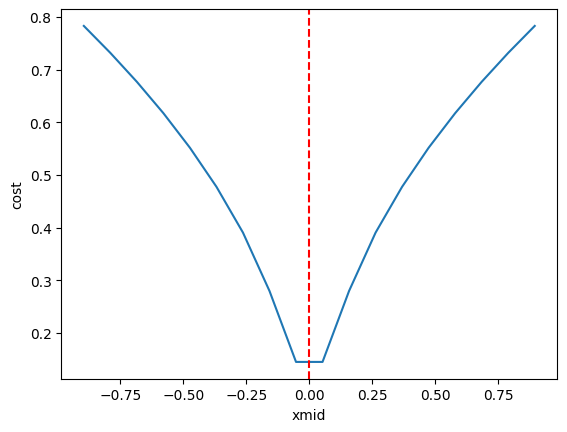

In [162]:
###### Case 1 ###### whether to split depends on k
# xmin, xmax = -1, 1
# ymin, ymax = -np.pi, np.pi
# k = 1

# def f(x, y):
#     return 1-np.cos(2*y + k*x)

# def I(x):
#     return 1*(ymax - ymin) - 0.5*(np.sin(2*ymax + k*x) - np.sin(2*ymin + k*x))

###### Case 2 ###### should split
# xmin, xmax = -1, 1
# ymin, ymax = -3, 3

# def f(x, y):
#     return np.where(x <= 0, normal(y, -1, 0.1), normal(y, -1, 0.1) + 2 * normal(y, 1, 0.5))

# def I(x):
#     return np.where(x <= 0, 1, 3)

###### Case 3 ######  left: sun + environ, right: environ, whether to split is sensitive to xmid
xmin, xmax = -1, 1
ymin, ymax = -5, 5
scale = 0.2

def gate(x):
    return np.clip(1-(x+0.5*scale)/scale, 0, 1)

def f(x, y):
    g = gate(x)
    return 10 * (g * normal(y, 0, 0.05) + (1-g) * normal(y, 1, 0.05)) + 1/(ymax - ymin)

def I(x):
    g = gate(x)
    return 11

##### Uncomment this for arbitarily defined f #####
# @np.vectorize
# def I(x):
#     return quad(lambda y: f(x, y), ymin, ymax)[0]

Ixy = quad(lambda x: I(x), xmin, xmax)[0]

def p(x, y):
    return f(x, y) / Ixy

def py_x(y, x):
    return f(x, y) / I(x)

def hat_px(x):  # sampling distribution of x
    return np.full_like(x, 1/(xmax - xmin))

def relMSE_optimal(hat_px, py_x, xmin, xmax, ymin, ymax):
    return quad(lambda y: np.sqrt(quad(lambda x: hat_px(x) * py_x(y, x)**2, xmin, xmax)[0]), ymin, ymax)[0]**2 - 1

def split_cost(t):
    Plx = (t - xmin) / (xmax - xmin)
    Prx = (xmax - t) / (xmax - xmin)
    def hat_plx(x):
        return hat_px(x) / Plx
    def hat_prx(x):
        return hat_px(x) / Prx

    error_opt_l, error_opt_r = relMSE_optimal(hat_plx, py_x, xmin, t, ymin, ymax), relMSE_optimal(hat_prx, py_x, t, xmax, ymin, ymax)
    return Plx * error_opt_l + Prx * error_opt_r

result = minimize_scalar(split_cost, bounds=(xmin, xmax), options={'maxiter': 100})
print(result)
xmid = result.x

t = np.linspace(xmin, xmax, 20)
cost = [split_cost(tt) for tt in t]
plt.figure()
plt.plot(t, cost)
plt.axvline(x=xmid, color='red', linestyle='--')
plt.xlabel('xmid')
plt.ylabel('cost')
plt.show()

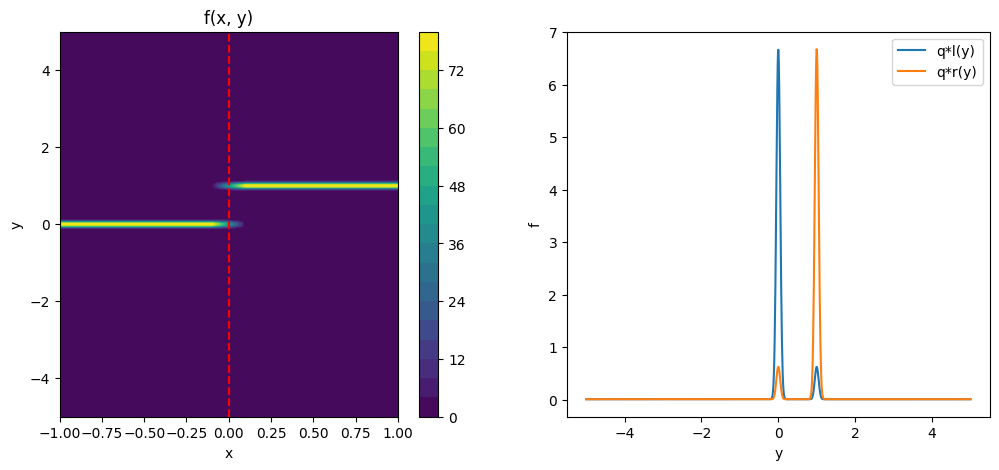

optimal relMSE, whole space, left, right: 0.1276 0.1276 0.1276


In [163]:
# Calculate the theoretically optimal distribution
def find_q_star(hat_px, py_x, xmin, xmax, ymin, ymax):
    @np.vectorize
    def q_star_unnorm(y):
        return np.sqrt(quad(lambda x: hat_px(x) * py_x(y, x)**2, xmin, xmax)[0])

    q_star_unnormalizer = quad(q_star_unnorm, ymin, ymax)[0]

    def q_star(y):
        return q_star_unnorm(y) / q_star_unnormalizer

    q_star_y_key_points = np.linspace(ymin, ymax, 1000)
    q_star_fp_key_points = q_star(q_star_y_key_points)

    def q_star_approx(y):
        return np.interp(y, q_star_y_key_points, q_star_fp_key_points)
    
    return q_star_approx

q_star = find_q_star(hat_px, py_x, xmin, xmax, ymin, ymax)
q_star_l = find_q_star(hat_px, py_x, xmin, xmid, ymin, ymax)
q_star_r = find_q_star(hat_px, py_x, xmid, xmax, ymin, ymax)

# Plot the 2D function
N = 1000
x = np.linspace(xmin, xmax, N)
y = np.linspace(ymin, ymax, N)
x, y = np.meshgrid(x, y)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plt.colorbar(ax1.contourf(x, y, f(x, y), 20))
ax1.axvline(x=xmid, color='red', linestyle='--')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title('f(x, y)')

# Plot the optimal distributions on the left and right
y = np.linspace(ymin, ymax, N)
# ax2.plot(y, f(xmin, y), label=f'f({xmin}, y)', alpha=0.5)
ax2.plot(y, q_star_l(y), label=f'q*l(y)', alpha=1.0)
# ax2.fill_between(y, 0, f(xmin, y), alpha=0.5)
# ax2.plot(y, f(xmax, y), label=f'f({xmax}, y)', alpha=0.5)
ax2.plot(y, q_star_r(y), label=f'q*r(y)', alpha=1.0)
# ax2.fill_between(y, 0, f(xmax, y), alpha=0.5)
ax2.set_xlabel('y')
ax2.set_ylabel('f')
ax2.legend()
plt.show()

# Plx = quad(lambda x: hat_px(x), xmin, xmid)[0]
# Prx = quad(lambda x: hat_px(x), xmid, xmax)[0]
Plx = (xmid - xmin) / (xmax - xmin)
Prx = (xmax - xmid) / (xmax - xmin)

def hat_plx(x):
    return hat_px(x) / Plx

def hat_prx(x):
    return hat_px(x) / Prx

error_opt_l, error_opt_r = relMSE_optimal(hat_plx, py_x, xmin, xmid, ymin, ymax), relMSE_optimal(hat_prx, py_x, xmid, xmax, ymin, ymax)
error_opt = Plx * error_opt_l + Prx * error_opt_r
print('optimal relMSE, whole space, left, right:', error_opt, error_opt_l, error_opt_r)